# Zimbabwe PriorCVAE model comparison

This notebook plots and compares different trained PriorCVAE model via empirical covariance and marginal statistics.

In [1]:
import os
import yaml
import random

import numpyro
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import flax.linen as nn
from priorCVAE.priors import SquaredExponential
from priorCVAE.datasets import GPDataset
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params
from experiments.zimbabwe.zimbabwe_utility import read_data, plot_prior_samples, plot_statistics

import jax.config as config
config.update("jax_enable_x64", True)


## Supporting function

In [2]:
def get_vae_samples(decoder, trained_decoder_params, ls, conditional, latent_dim, n=1000):
    key = jax.random.PRNGKey(random.randint(0, 9999))
    rng, z_rng = jax.random.split(key, 2)
    z = jax.random.normal(z_rng, (n, latent_dim))
    if conditional:
        c = ls * jnp.ones((z.shape[0], 1))
        z = jnp.concatenate([z, c], axis=-1)
    vae_samples = decoder.apply({'params': trained_decoder_params}, z)
    
    return vae_samples

In [3]:
def decoder_predictions(model_dir, pred_ls, n_samples):
    cfg_path = os.path.join(model_dir, "files", "config.yaml")
    with open(cfg_path, 'r') as file:
        cfg_data = yaml.safe_load(file)

    conditional = cfg_data["normalize"]["value"]
    latent_dim = cfg_data["latent_dim"]["value"]
    normalize = cfg_data["normalize"]["value"]
    dec_activation_fn = cfg_data["dec_activation"]["value"]["_target_"]
    dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])
    
    trained_decoder_params = load_model_params(os.path.join(model_dir, "model"))["decoder"]
    
    output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
    hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
    decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)
    
    vae_samps = []
    for ls in pred_ls:
        vae_samps.append(get_vae_samples(decoder, trained_decoder_params, ls, conditional, latent_dim,
                                         n=n_samples))
    
    vae_samps = jnp.array(vae_samps).reshape((len(pred_ls), n_samples, -1))
    
    return vae_samps, normalize

## Loading setup

In [4]:
models_dir = ["../outputs/yzki4cge/", "../outputs/gs352gqu/"]

In [5]:
data_path = "../data/zimbabwe_admin2/shapefile.shp"
n_samples = 1000
ls_to_plot = jnp.linspace(0.1, 1, 5)

In [6]:
model_preds = []
normalize = None
for model_dir in models_dir:
    m_p, normalize = decoder_predictions(model_dir, ls_to_plot, n_samples)
    model_preds.append(m_p)

In [7]:
x, _ = read_data(data_path, normalize=normalize)
data_generator = GPDataset(kernel=SquaredExponential(), x=x, sample_lengthscale=False)

/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/vermap1/projects/PriorCVAE_JAX/experiments/zimbabwe/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


In [8]:
prior_samples = []

for ls in ls_to_plot:
    data_generator.kernel.lengthscale = ls
    _, samps, _ = data_generator.simulatedata(n_samples=n_samples)
    prior_samples.append(samps)

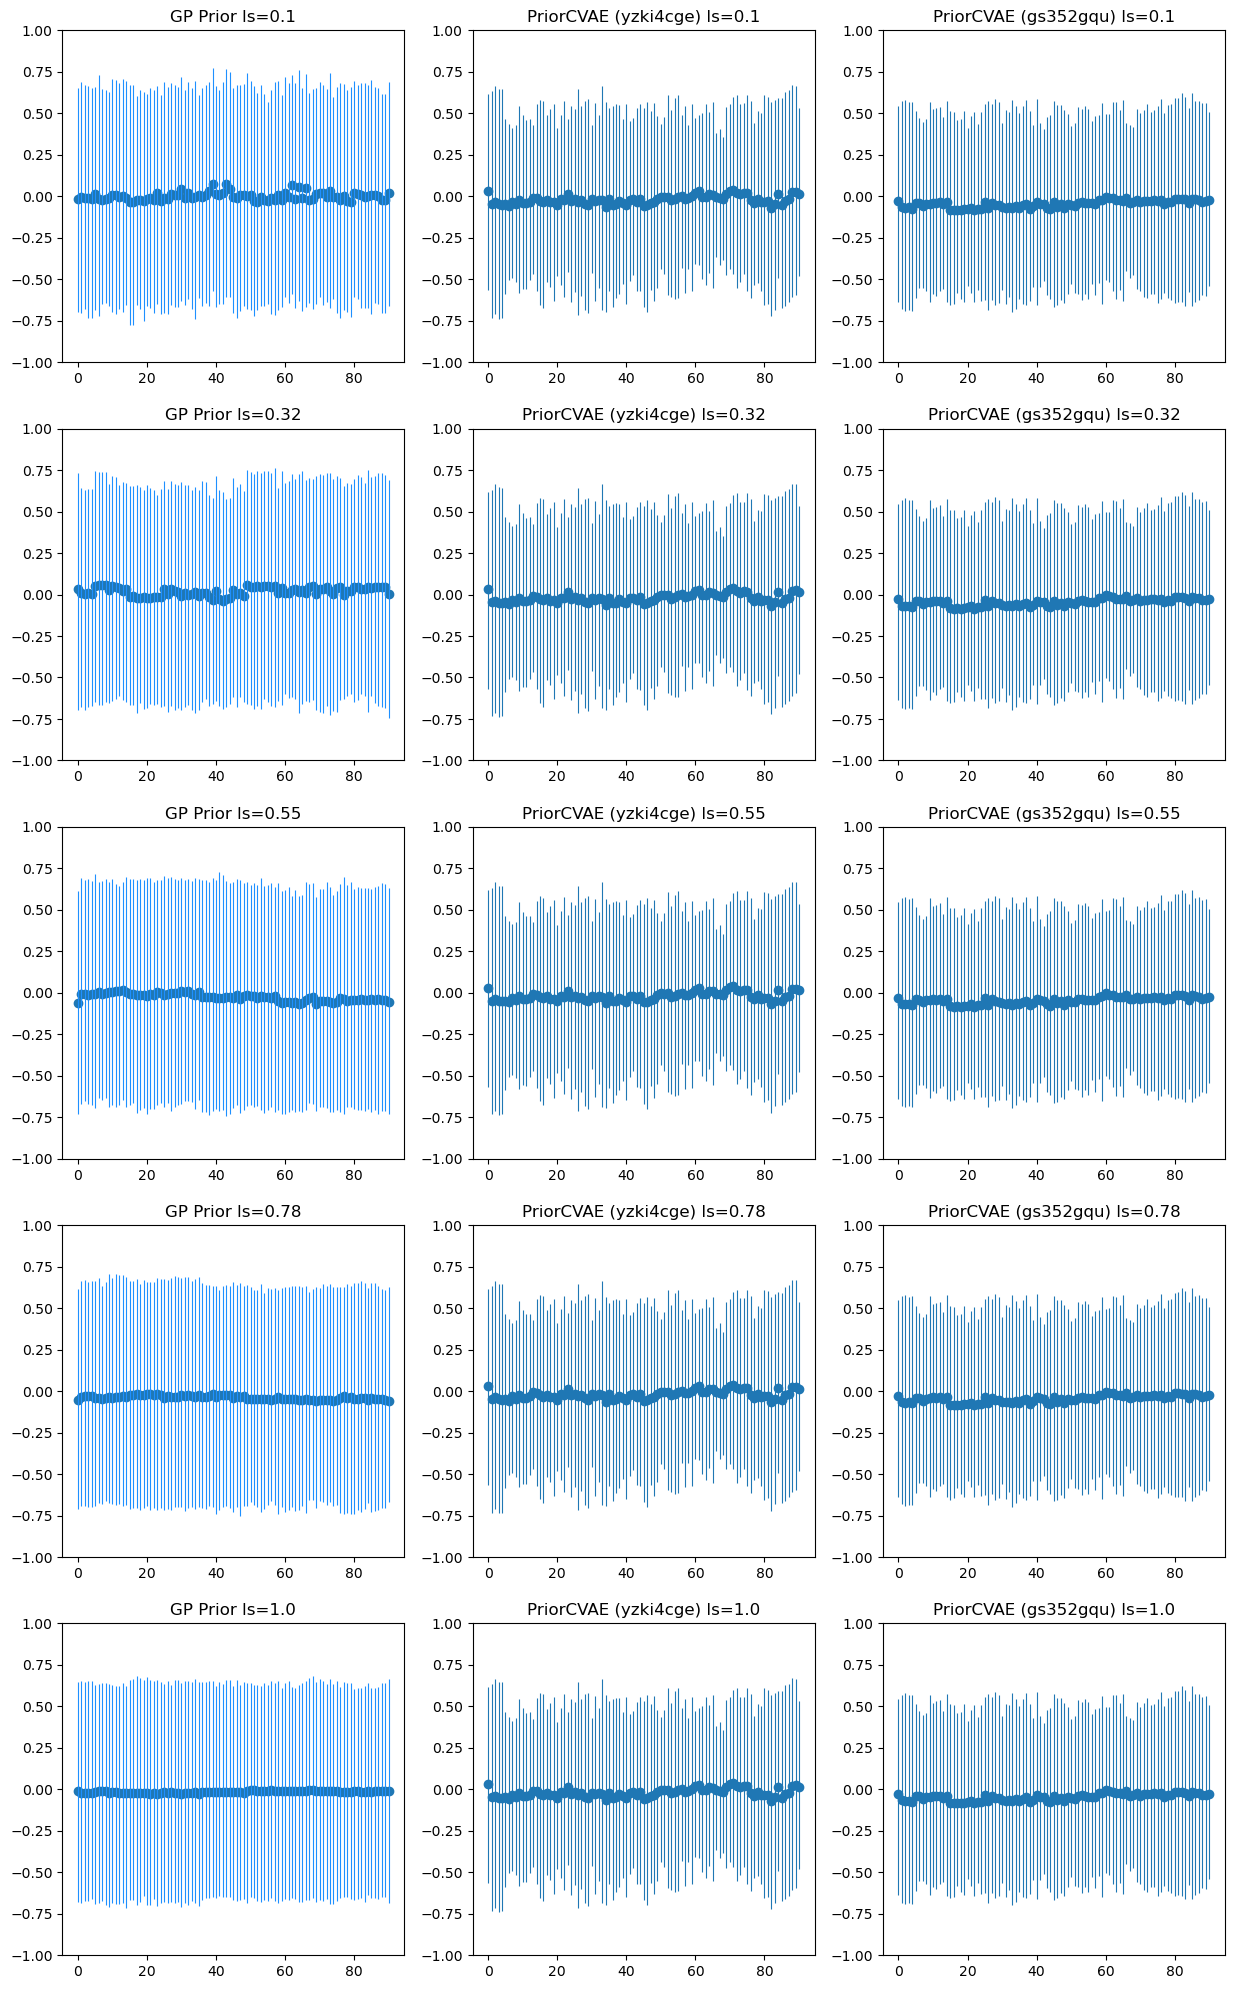

In [9]:
fig, axs = plt.subplots(ls_to_plot.shape[-1], len(models_dir) + 1, figsize=(15, 25))

# First cols for true prior samps
for i, p_s in enumerate(prior_samples):
    
    gp_samples_mean = jnp.mean(p_s, axis=0)
    gp_draws_25, gp_draws_75 = jnp.quantile(p_s, jnp.array([.25, .75]), axis=0)
    
    axs[i][0].scatter(jnp.arange(len(gp_samples_mean)), gp_samples_mean)
    axs[i][0].vlines(x=jnp.arange(len(gp_draws_25)),
               ymin=gp_draws_25,
               ymax=gp_draws_75,
               color="dodgerblue",
               label="GP",
               linewidth=.8)
    axs[i][0].set_title(f"GP Prior ls={round(ls_to_plot[i], 2)}")
    axs[i][0].set_ylim([-1, 1])

for i, model_samps in enumerate(model_preds):
    for row in range(model_samps.shape[0]):
        vae_gp_samps = model_samps[i]
        
        vae_samples_mean = jnp.mean(vae_gp_samps, axis=0)
        vae_draws_25, vae_draws_75 = jnp.quantile(vae_gp_samps, jnp.array([.25, .75]), axis=0)
        
        axs[row][i+1].scatter(jnp.arange(len(vae_samples_mean)), vae_samples_mean)
        
        axs[row][i+1].vlines(x=jnp.arange(len(vae_draws_25)),
               ymin=vae_draws_25,
               ymax=vae_draws_75,
               label="VAE",
               linewidth=.8)
        axs[row][i+1].set_title(f"PriorCVAE ({models_dir[i].split('/')[2]}) ls={round(ls_to_plot[row], 2)}")
        axs[row][i+1].set_ylim([-1, 1])

plt.show()

## Plot Covariance

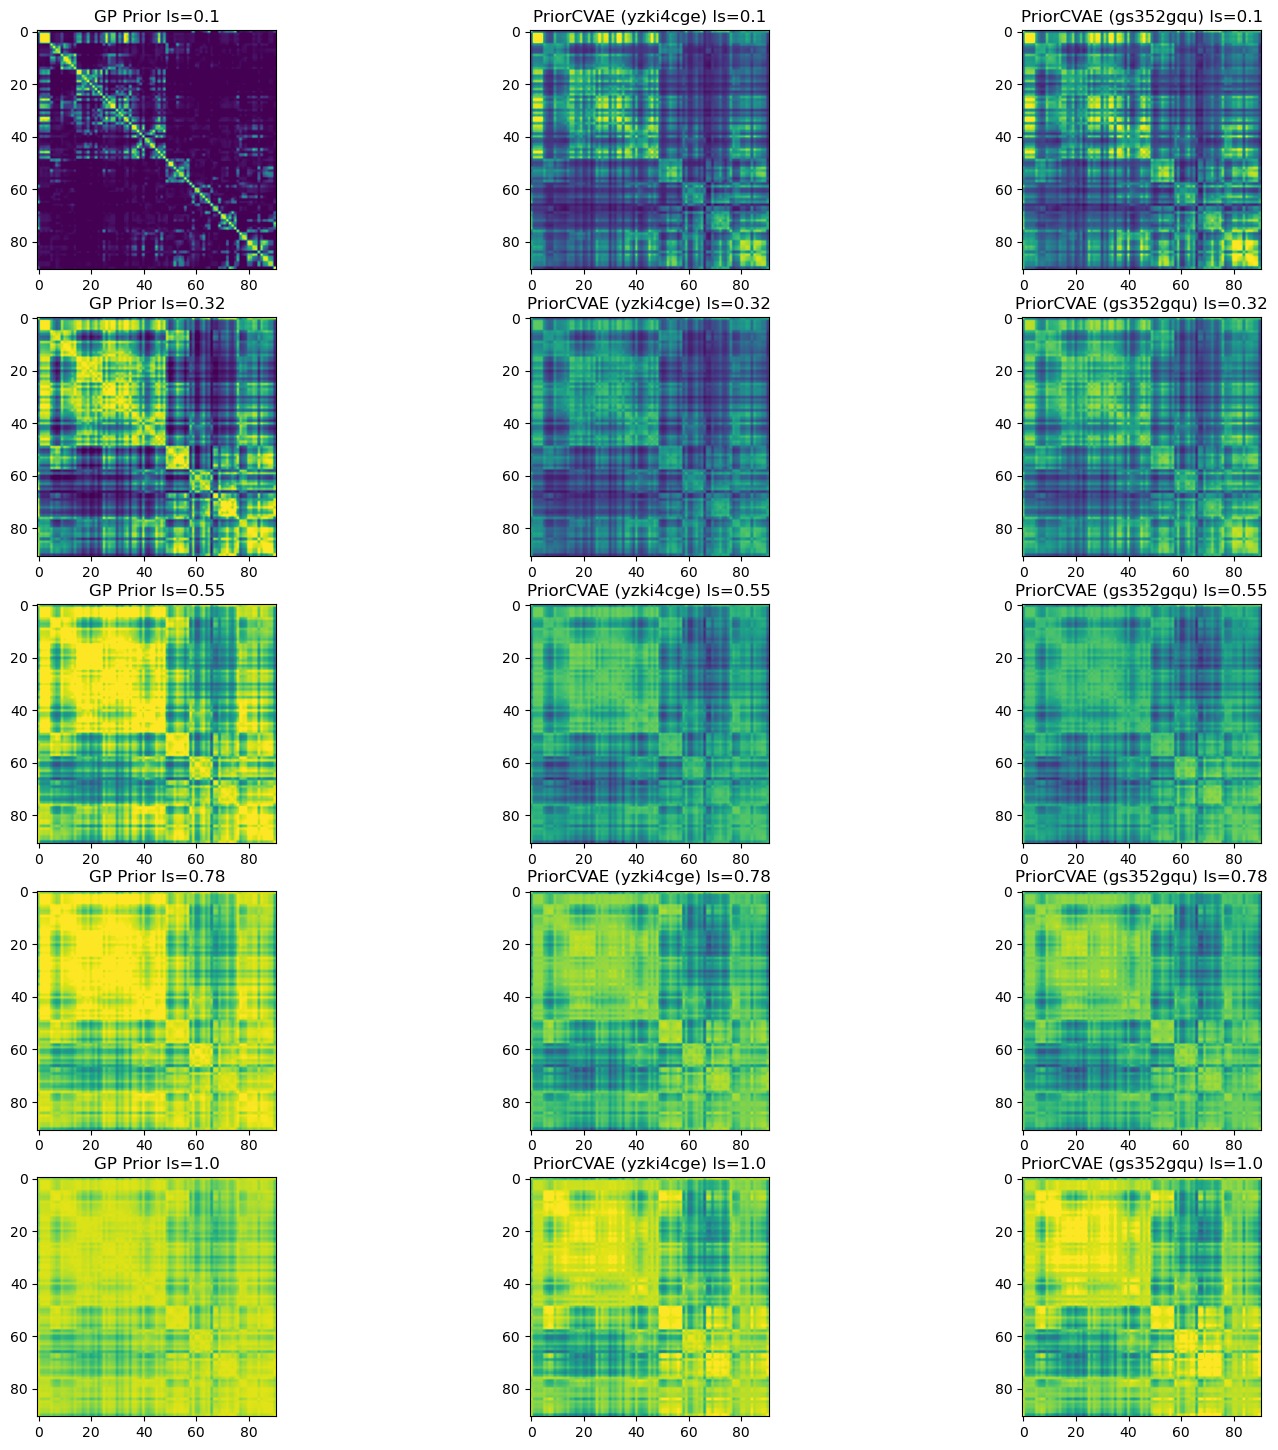

In [12]:
fig, axs = plt.subplots(ls_to_plot.shape[-1], len(models_dir) + 1, figsize=(18, 18))

# First cols for true prior samps
for i, p_s in enumerate(prior_samples):
    gp_cov = jnp.cov(p_s.T)
    
    axs[i][0].imshow(gp_cov, vmin=0, vmax=1)
    axs[i][0].set_title(f"GP Prior ls={round(ls_to_plot[i], 2)}")

for i, model_samps in enumerate(model_preds):
    for row in range(model_samps.shape[0]):
        vae_gp_samps = model_samps[row]
        vae_cov = jnp.cov(vae_gp_samps.T)
        
        axs[row][i+1].imshow(vae_cov, vmin=0, vmax=1)
        axs[row][i+1].set_title(f"PriorCVAE ({models_dir[i].split('/')[2]}) ls={round(ls_to_plot[row], 2)}")

plt.show()